# Comparing different imputation strategies on a toy data set

Using the following code, generate bivariate data with n=100 drawn from a Gaussian distribution with $\mu_y = 0, \mu_x= 1$, standard deviation $\sigma_y = \sigma_x = 1$ and correlation $\rho =0.3$. Add a MCAR missing mask on the second variable only, distributed as a Bernoulli with parameter $p=0.6$.

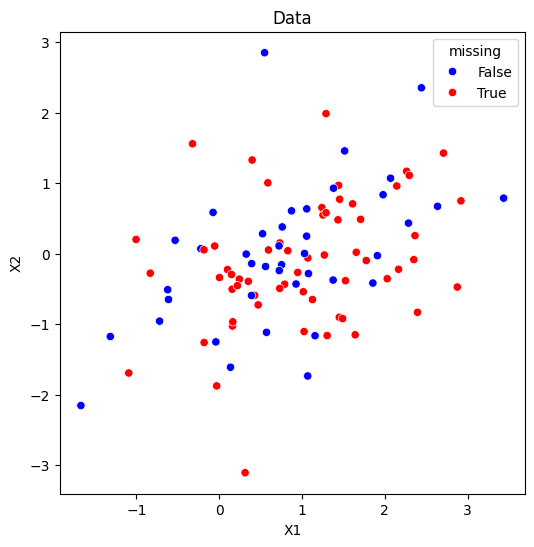

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

# Nombre d'observations
n = 100
true_mean = np.array([1, 0])
true_sigma = np.array([[1, 0.3], [0.3, 1]])
missing_probability = 0.6
Nb_mutliple_imputations = 50
Nb_repetitions = 1000

# Génération des données
don = multivariate_normal.rvs(mean=true_mean, cov=true_sigma, size=n)

# On part du tableau 'don' (numpy array de taille (n, 2))
donmiss = don.copy()

# Tirage aléatoire de missing_probability des indices parmi 1..n
indNA = np.random.choice(n, size=int(missing_probability * n), replace=False)

# Mise à NaN de la 2ème colonne (indice 1 en Python)
donmiss[indNA, 1] = np.nan

donplot = don.copy()
missing = np.isin(np.arange(0, n), indNA)

donplot = pd.DataFrame({
    "X1": donplot[:, 0],
    "X2": donplot[:, 1],
    "missing": missing
})

# Visualisation
plt.figure(figsize=(6, 6))
sns.scatterplot(data=donplot, x="X1", y="X2", hue="missing", palette={True: "red", False: "blue"})
plt.title("Data")
plt.show()

1. On the complete observations only, compute the empirical mean of 𝑦, its standard deviation and the correlation between 𝑥 and 𝑦.

In [2]:
######################
#### TO DO

complete_case = donmiss[~np.isnan(donmiss[:,1])]
muhat = np.mean(complete_case[:,1])
sigmahat = np.std(complete_case[:,1])
corhat = np.corrcoef(complete_case[:,0], complete_case[:,1])[0,1]

# Assemblage en DataFrame
df_res = pd.DataFrame(
    [muhat, sigmahat, corhat],
    index=["muhat_y", "sigmahat_y", "cor"],
    columns=["Complete Case"]
)

true_value = np.array([true_mean[1], np.sqrt(true_sigma[1,1]), true_sigma[0,1]/(np.sqrt(true_sigma[0,0]*true_sigma[1,1])) ])
df_res["TRUE"] = true_value

print(df_res)
#### END TO DO
######################


            Complete Case  TRUE
muhat_y         -0.015346   0.0
sigmahat_y       0.995181   1.0
cor              0.529885   0.3


2. Use mean imputation to create an imputed data set.

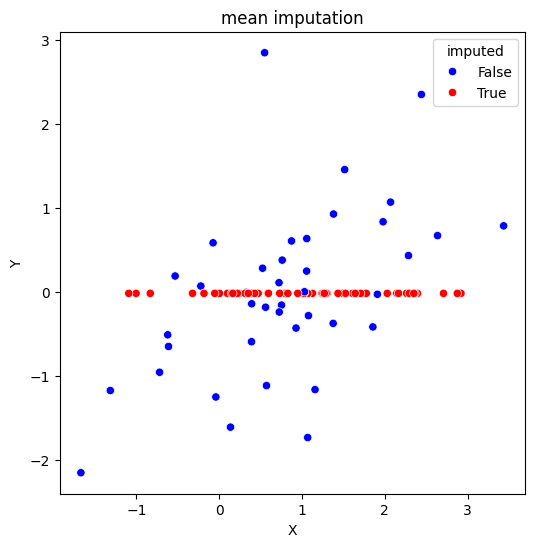

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# On part de donmiss (numpy array avec NaN dans la 2e colonne)

# Copie des données
donMean = donmiss.copy()

####################
### TO DO
##### Remplacer les données manquantes par la moyennes
##### Ajouter une variable imputed valant 1 si la données est manquante
##### et 0 sinon
##### Stocker le tout (jeu de données imputé + imputed) dans un dataframe 'df' pandas

# Remplacement des NaN par la moyenne de la colonne 2
col_mean = np.nanmean(donMean[:, 1])
donMean[indNA, 1] = col_mean

# Création de la variable "imputed" (True si la valeur était manquante)
imputed = np.isin(np.arange(0, n), indNA)

# Conversion en DataFrame pour ggplot-like
df = pd.DataFrame({
    "X": donMean[:, 0],
    "Y": donMean[:, 1],
    "imputed": imputed
})

### END TO DO
####################

# Visualisation
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="X", y="Y", hue="imputed", palette={True: "red", False: "blue"})
plt.title("mean imputation")
plt.show()



3. Create a new imputed data set via linear regression

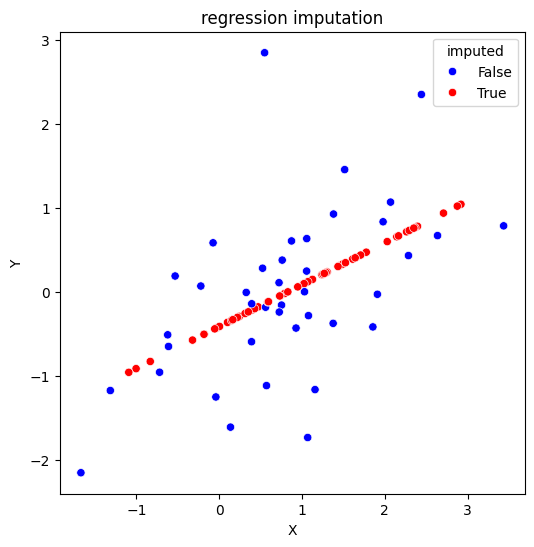

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# On part de donmiss (numpy array avec NaN dans la 2e colonne)

# Conversion en DataFrame pour plus de clarté
df_miss = pd.DataFrame(donmiss, columns=["X", "Y"])

# Copie des données pour imputation
donReg = df_miss.copy()

####################
### TO DO
##### Effectuer une régression linéaire de Y sur X sur les données complètes
##### Imputer les données manquantes grâce à cette régression linéaire
##### Ajouter une variable imputed valant 1 si la données est manquante
##### et 0 sinon
##### Stocker le tout (jeu de données imputé + imputed) dans le dataframe 'donReg'

# Régression linéaire sur les lignes sans NaN
reg = LinearRegression()
mask_train = ~df_miss["Y"].isna()
reg.fit(df_miss.loc[mask_train, ["X"]], df_miss.loc[mask_train, "Y"])

# Prédiction pour les valeurs manquantes
donReg.loc[indNA, "Y"] = reg.predict(donReg.loc[indNA, ["X"]])

# Variable indicatrice : True si imputée
imputed = np.isin(np.arange(0, n), indNA)
donReg["imputed"] = imputed


##### END TO DO
#####################



# Visualisation
plt.figure(figsize=(6, 6))
sns.scatterplot(data=donReg, x="X", y="Y", hue="imputed", palette={True: "red", False: "blue"})
plt.title("regression imputation")
plt.show()


4. Create a new imputed data set via stochastic linear regression

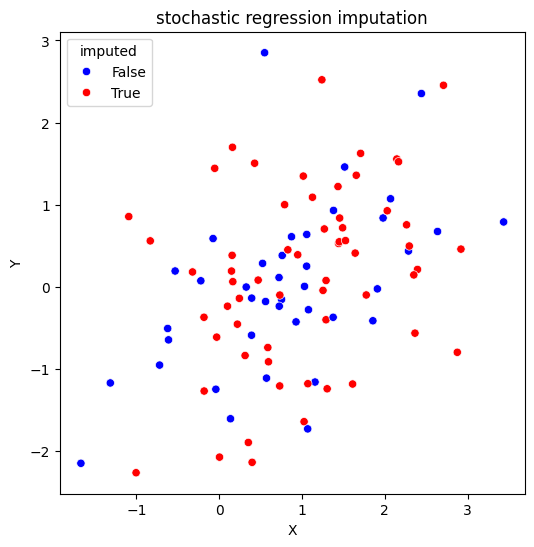

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# On part de donmiss (numpy array avec NaN dans la 2e colonne)
df_miss = pd.DataFrame(donmiss, columns=["X", "Y"])

# Copie des données manquantes
donStochReg = df_miss.copy()

####################
### TO DO
##### Effectuer une régression linéaire de Y sur X sur les données complètes
##### Imputer les données manquantes grâce à cette régression linéaire
##### En ajoutant un bruit (estimé sur les données complètes) sur les données imputées
##### Ajouter une variable imputed valant 1 si la données est manquante
##### et 0 sinon
##### Stocker le tout (jeu de données imputé + imputed) dans le dataframe 'donStochReg'

# Régression linéaire sur les données observées
reg = LinearRegression()
mask_train = ~df_miss["Y"].isna()
reg.fit(df_miss.loc[mask_train, ["X"]], df_miss.loc[mask_train, "Y"])

# Résidus pour estimer sigma (écart-type des erreurs)
residuals = df_miss.loc[mask_train, "Y"] - reg.predict(df_miss.loc[mask_train, ["X"]])
sigma = residuals.std(ddof=1)  # correspond à summary(reg)$sigma en R

# Imputation stochastique : prédiction + bruit normal
pred = reg.predict(donStochReg.loc[indNA, ["X"]])
donStochReg.loc[indNA, "Y"] = pred + np.random.normal(0, sigma, size=len(indNA))

# Variable indicatrice : True si imputée
imputed = np.isin(np.arange(0, n), indNA)
donStochReg["imputed"] = imputed

#### END TO DO
#####################



# Visualisation
plt.figure(figsize=(6, 6))
sns.scatterplot(data=donStochReg, x="X", y="Y", hue="imputed", palette={True: "red", False: "blue"})
plt.title("stochastic regression imputation")
plt.show()

5. For each above imputation, compute the empirical mean of $y$, its standard deviation and the correlation between $x$ and $y$. What is the best strategy?

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import t

# On construit la matrice "res" comme en R (colonnes : mean, reg, stoch)
res = np.column_stack([donMean[:, 1], donReg["Y"].values, donStochReg["Y"].values])

# Moyenne et écart-type par colonne
MM = np.mean(res, axis=0)
SD = np.std(res, axis=0, ddof=1)  # sd = std avec ddof=1

# Corrélations entre chaque méthode et X d'origine (colonne 0 de donmiss)
COR = [np.corrcoef(res[:, j], donmiss[:, 0])[0, 1]
       for j in range(res.shape[1])]

# Assemblage en DataFrame
df_res = pd.DataFrame(
    [MM, SD, COR],
    index=["muhat_y", "sigmahat_y", "cor"],
    columns=["MEAN", "REG", "STOCH"]
)

true_value = np.array([true_mean[1], np.sqrt(true_sigma[1,1]), true_sigma[0,1]/(np.sqrt(true_sigma[0,0]*true_sigma[1,1])) ])
df_res["TRUE"] = true_value

print(df_res)


                MEAN       REG     STOCH  TRUE
muhat_y    -0.015346  0.047752  0.077789   0.0
sigmahat_y  0.632579  0.733164  1.061116   1.0
cor         0.355421  0.681605  0.404514   0.3


6. Compute a confidence interval for $\mu_y$ based on each imputed data set. Compute the coverage of this confidence interval based on 10.000 repetitions.  Comment.

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import t, ttest_1samp
import scipy.stats as sps
from sklearn.linear_model import LinearRegression

# --- Fonction d'évaluation des imputations ---
def statcheck(don: np.ndarray):
    """
    don : numpy array de taille (n, 2) avec colonnes [X, Y]
    Retourne muhat, sigmahat, corhat, cov, widthCI
    """
    Y = don[:, 1]
    X = don[:, 0]

    # Estimateur de la moyenne
    muhat = np.mean(Y)

    # Corrélation X-Y
    corhat = np.corrcoef(X, Y)[0, 1]

    # IC 95% pour la moyenne
    n_obs = len(Y)
    #n_complete = n_obs*missing_probability
    #se = sigma_hat_with_ood / np.sqrt(n_complete)
    #gaussian_quant = sps.norm.ppf(0.975, loc=0, scale=1)
    se = np.std(Y) / np.sqrt(n_obs)
    t_val = t.ppf(0.975, df=n_obs - 1)
    ci_low, ci_high = muhat - t_val * se, muhat + t_val * se

    # Vérifie si true_mean[1] est dans l'IC
    cov = int((true_mean[1] <= ci_high) & (true_mean[1] >= ci_low))

    sigmahat = np.std(Y)
    widthCI = ci_high - ci_low

    return dict(muhat=muhat, sigmahat=sigmahat, corhat=corhat, cov=cov, widthCI=widthCI)


# --- Fonction MCAR ---
def MCAR(don: np.ndarray, percent: float):
    """
    Remplace percent% des Y par NaN
    """
    don_copy = don.copy()
    n = don.shape[0]
    indNA = np.random.choice(n, size=int(percent * n), replace=False)
    don_copy[indNA, 1] = np.nan
    return don_copy


# --- Fonction d’imputation ---
def Impute(don: np.ndarray):
    """
    Applique mean, regression et stochastic regression imputation
    """
    df = pd.DataFrame(don, columns=["X", "Y"])
    indNA = df[df["Y"].isna()].index

    # --- Mean Imputation ---
    donMean = df.copy()
    donMean.loc[indNA, "Y"] = df["Y"].mean(skipna=True)

    # --- Regression Imputation ---
    mask_train = ~df["Y"].isna()
    reg = LinearRegression().fit(df.loc[mask_train, ["X"]], df.loc[mask_train, "Y"])
    donReg = df.copy()
    donReg.loc[indNA, "Y"] = reg.predict(df.loc[indNA, ["X"]])

    # --- Stochastic Regression Imputation ---
    residuals = df.loc[mask_train, "Y"] - reg.predict(df.loc[mask_train, ["X"]])
    sigma = residuals.std(ddof=1)
    donStochReg = donReg.copy()
    donStochReg.loc[indNA, "Y"] = donReg.loc[indNA, "Y"] + np.random.normal(0, sigma, size=len(indNA))

    return dict(
        donMean=donMean.to_numpy(),
        donReg=donReg.to_numpy(),
        donStochReg=donStochReg.to_numpy()
    )


# --- Simulation (1000 réplications) ---
nrep = 1000
dd = []

for _ in range(nrep):
    # Données simulées
    don = np.random.multivariate_normal(true_mean, true_sigma, size=n)

    # MCAR
    donmiss = MCAR(don, percent=missing_probability)
    sigma_hat_with_ood = np.std(donmiss[~np.isnan(donmiss[:,1]) , 1])

    # Imputation
    imputed = Impute(donmiss)

    # Statistiques
    stats_all = [statcheck(imputed["donMean"]),
                 statcheck(imputed["donReg"]),
                 statcheck(imputed["donStochReg"])]

    dd.append([list(s.values()) for s in stats_all])

# Moyenne sur toutes les réplications
dd = np.array(dd)  # shape (nrep, 3, 5)
RES = dd.mean(axis=0)  # shape (3,5)

# Mise en DataFrame
RES = pd.DataFrame(
    RES.T,
    columns=["MEAN", "REGRESSION", "REGSTO"],
    index=["muhat", "sigmahat", "corhat", "cov_mu", "width_CI_mu"]
)

true_value = np.array([true_mean[1], np.sqrt(true_sigma[1,1]), true_sigma[0,1]/(np.sqrt(true_sigma[0,0]*true_sigma[1,1])), 0.95, np.nan ])
RES["TRUE"] = true_value

print(RES)

                 MEAN  REGRESSION    REGSTO  TRUE
muhat        0.003760    0.004245  0.005861  0.00
sigmahat     0.618687    0.668935  0.981391  1.00
corhat       0.186113    0.428542  0.292388  0.30
cov_mu       0.554000    0.603000  0.737000  0.95
width_CI_mu  0.245522    0.265462  0.389459   NaN


7. Implement MICE imputation and stochastic linear regression by first bootstrapping the complete data set. Compute the same quantities (mean, covariance, coverage...). Comment.

In [8]:
from pickle import TRUE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



import numpy as np
import pandas as pd
from scipy.stats import t, ttest_1samp
import scipy.stats as sps
from sklearn.linear_model import LinearRegression

# --- Fonction d'évaluation des imputations ---
def statcheck(don: np.ndarray):
    """
    don : numpy array de taille (n, 2) avec colonnes [X, Y]
    Retourne muhat, sigmahat, corhat, cov, widthCI
    """
    Y = don[:, 1]
    X = don[:, 0]

    # Estimateur de la moyenne
    muhat = np.mean(Y)

    # Corrélation X-Y
    corhat = np.corrcoef(X, Y)[0, 1]

    # IC 95% pour la moyenne
    n_obs = len(Y)
    #n_complete = n_obs*missing_probability
    se = np.std(Y) / np.sqrt(n_obs)
    #gaussian_quant = sps.norm.ppf(0.975, loc=0, scale=1)
    tval = t.ppf(0.975, df=n_obs - 1)
    ci_low, ci_high = muhat - tval * se, muhat + tval * se

    # Vérifie si true_mean[1] est dans l'IC
    cov = int((true_mean[1] <= ci_high) & (true_mean[1] >= ci_low))

    sigmahat = np.std(Y)
    widthCI = ci_high - ci_low

    return dict(muhat=muhat, sigmahat=sigmahat, corhat=corhat, cov=cov, widthCI=widthCI)


# --- Fonction MCAR ---
def MCAR(don: np.ndarray, percent: float):
    """
    Remplace percent% des Y par NaN
    """
    don_copy = don.copy()
    n = don.shape[0]
    indNA = np.random.choice(n, size=int(percent * n), replace=False)
    don_copy[indNA, 1] = np.nan
    return don_copy


# --- Fonction d’imputation ---
def Impute(don: np.ndarray):
    """
    Applique mean, regression et stochastic regression imputation
    """
    df = pd.DataFrame(don, columns=["X", "Y"])
    indNA = df[df["Y"].isna()].index

    # --- Mean Imputation ---
    donMean = df.copy()
    donMean.loc[indNA, "Y"] = df["Y"].mean(skipna=True)

    # --- Regression Imputation ---
    mask_train = ~df["Y"].isna()
    reg = LinearRegression().fit(df.loc[mask_train, ["X"]], df.loc[mask_train, "Y"])
    donReg = df.copy()
    donReg.loc[indNA, "Y"] = reg.predict(df.loc[indNA, ["X"]])

    # --- Stochastic Regression Imputation ---
    residuals = df.loc[mask_train, "Y"] - reg.predict(df.loc[mask_train, ["X"]])
    sigma = residuals.std(ddof=1)
    donStochReg = donReg.copy()
    donStochReg.loc[indNA, "Y"] = donReg.loc[indNA, "Y"] + np.random.normal(0, sigma, size=len(indNA))

    # --- MICE
    donMice = df.copy()

    ###########
    #### TO DO
    #### Impute missing data via mice and store them into donMICE

    imp_mean = IterativeImputer(random_state=0, sample_posterior=True)
    imp_mean.fit(donMice)
    donMice = imp_mean.transform(donMice)

    #### END TO DO
    ###########

    # Boostraped stochastic regression

    donRegBoot = df.copy()

    ###########
    #### TO DO
    #### Bootstrap the complete data and train a linear regression
    #### on the boostrap sample
    #### Impute data via stochastic linear regression as above
    #### Store them into donRegBoot

    mask_train = ~df["Y"].isna()
    Bootstrap_index = np.random.choice(df.index[mask_train], size=len(df.index[mask_train]), replace=True)
    reg = LinearRegression().fit(df.loc[Bootstrap_index, ["X"]], df.loc[Bootstrap_index, "Y"])

    donRegBoot.loc[indNA, "Y"] = reg.predict(donRegBoot.loc[indNA, ["X"]])
    residuals = donRegBoot.loc[mask_train, "Y"] - reg.predict(donRegBoot.loc[mask_train, ["X"]])
    sigma = residuals.std(ddof=1)
    donRegBoot.loc[indNA, "Y"] = donRegBoot.loc[indNA, "Y"] + np.random.normal(0, sigma, size=len(indNA))

    #### END TO DO
    ###########

    return dict(
        donMean=donMean.to_numpy(),
        donReg=donReg.to_numpy(),
        donStochReg=donStochReg.to_numpy(),
        donMice=donMice,
        donRegBoot = donRegBoot.to_numpy()
    )



# --- Simulation ---
nrep = Nb_repetitions
dd = []

for _ in range(nrep):
    # Données simulées
    don = np.random.multivariate_normal(true_mean, true_sigma, size=n)

    # MCAR
    donmiss = MCAR(don, percent=missing_probability)

    # Imputation
    imputed = Impute(donmiss)

    # Statistiques
    stats_all = [statcheck(imputed["donMean"]),
                 statcheck(imputed["donReg"]),
                 statcheck(imputed["donStochReg"]),
                 statcheck(imputed["donMice"]),
                 statcheck(imputed["donRegBoot"])]

    dd.append([list(s.values()) for s in stats_all])

# Moyenne sur toutes les réplications
dd = np.array(dd)  # shape (nrep, 3, 5)
RES = dd.mean(axis=0)  # shape (3,5)

# Mise en DataFrame
RES = pd.DataFrame(
    RES.T,
    columns=["MEAN", "REGRESSION", "REGSTO", "MICE", "BOOT REGSTO"],
    index=["muhat", "sigmahat", "corhat", "cov_mu", "width_CI_mu"]
)

true_value = np.array([true_mean[1], np.sqrt(true_sigma[1,1]), true_sigma[0,1]/(np.sqrt(true_sigma[0,0]*true_sigma[1,1])) ])
RES["TRUE"] = [true_value[0], true_value[1], true_value[2], 0.95 , np.nan]

print(RES)

                 MEAN  REGRESSION    REGSTO      MICE  BOOT REGSTO  TRUE
muhat        0.003797    0.004199  0.002462  0.003593    -0.000967  0.00
sigmahat     0.619077    0.667168  0.984001  0.950221     0.999385  1.00
corhat       0.181116    0.417581  0.288011  0.248712     0.279747  0.30
cov_mu       0.581000    0.617000  0.753000  0.791000     0.703000  0.95
width_CI_mu  0.245677    0.264761  0.390494  0.377089     0.396599   NaN


8. Implement Multiple Imputation and compute that same quantities as above. Compare to the other imputation strategies.

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.linear_model import LinearRegression


def IMPMULT(method: str, M: int):
    # --- Génération des données complètes ---
    don = np.random.multivariate_normal(true_mean, true_sigma, size=n)
    df = pd.DataFrame(don, columns=["X", "Y"])

    # --- Génération des valeurs manquantes ---
    donmiss = df.copy()

    if method == "MCAR":
        indNA = np.random.choice(n, size=int(missing_probability * n), replace=False)
        donmiss.loc[indNA, "Y"] = np.nan

    elif method == "MAR":
        donmiss.loc[donmiss["X"] <= 1, "Y"] = np.nan
        indNA = donmiss.index[donmiss["Y"].isna()]

    elif method == "MNAR":
        donmiss.loc[donmiss["Y"] <= 0, "Y"] = np.nan
        indNA = donmiss.index[donmiss["Y"].isna()]

    # --- Multiple Imputation ---
    ThetaHat = np.empty(M)
    VarThetaHat = np.empty(M)
    Correlation = np.empty(M)
    StandardDev = np.empty(M)

    for j in range(M):
        donStochReg = donmiss.copy()

        # Bootstrap
        indsample = np.random.choice(n, size=n, replace=True)
        df_boot = donmiss.iloc[indsample].dropna()

        # Régression
        reg = LinearRegression().fit(df_boot[["X"]], df_boot["Y"])

        # Estimation de sigma (écart-type des résidus bootstrapés)
        residuals = df_boot["Y"] - reg.predict(df_boot[["X"]])
        sigma_reg = residuals.std(ddof=1)

        # Imputation stochastique
        preds = reg.predict(donmiss.loc[indNA, ["X"]])
        noise = np.random.normal(0, sigma_reg, size=len(indNA))
        donStochReg.loc[indNA, "Y"] = preds + noise

        # Sauvegarde des estimateurs
        ThetaHat[j] = donStochReg["Y"].mean()
        VarThetaHat[j] = donStochReg["Y"].var(ddof=1)
        Correlation[j] = np.corrcoef(donStochReg["X"], donStochReg["Y"])[0, 1]

    ##############
    #### TO DO
    #### Aggregate the results and compute confidence intervals

    # --- Combinaison avec les règles de Rubin ---
    ThetaHatBar = ThetaHat.mean()
    CorrelationMean = Correlation.mean()
    StandardDevMean = VarThetaHat[0]

    # Intervalle de confiance à 95%
    T_var = VarThetaHat.mean()/n + (1 + 1/M) * ThetaHat.var(ddof=1)

    # Degrés de liberté approx.
    IMddf = (M - 1) * (1 + (VarThetaHat.mean()/n) / ((M + 1) * ThetaHat.var(ddof=1)))**2

    # IC à 95%
    tval = t.ppf(0.975, df=IMddf)
    IMINF = ThetaHatBar - tval * np.sqrt(T_var)
    IMSUP = ThetaHatBar + tval * np.sqrt(T_var)

    IMINCI = int((true_mean[1] <= IMSUP) and (true_mean[1] >= IMINF))
    IMWIDTH = IMSUP - IMINF

    #### END TO DO
    ###############################

    res = pd.DataFrame(
        [[ThetaHatBar], [StandardDevMean], [CorrelationMean], [IMINF], [IMSUP], [IMINCI], [IMWIDTH]],
        index=["ThetaHatBar", "Sigmahat", "Correlation", "IMINF", "IMSUP", "IMINCI", "IMWIDTH"],
        columns=["IM"]
    )
    return res

MAT = np.zeros((7,1))
for i in range(Nb_mutliple_imputations):
    MAT += IMPMULT("MCAR", M=10).to_numpy()

u = MAT/Nb_mutliple_imputations

res_mcar = pd.DataFrame(
        [u[0], u[1], u[2], u[3], u[4], u[5], u[6]],
        index=["ThetaHatBar", "ThetaHatVar", "Correlation", "IMINF", "IMSUP", "IMINCI", "IMWIDTH"],
        columns=["IM"]
    )

res_mult = [u[0], u[1], u[2], u[5], u[6]]

true_value = np.array([true_mean[1], np.sqrt(true_sigma[1,1]), true_sigma[0,1]/(np.sqrt(true_sigma[0,0]*true_sigma[1,1])) ])
RES["TRUE"] = [true_value[0], true_value[1], true_value[2], 0.95 , np.nan]

res_mult = u[[0,1,2,5,6]]
pos = int(len(RES.columns)-1)
final_result = RES.copy()
final_result.insert(loc = pos, column = "MI", value = res_mult)
print(final_result)


                 MEAN  REGRESSION    REGSTO      MICE  BOOT REGSTO        MI  \
muhat        0.003797    0.004199  0.002462  0.003593    -0.000967  0.009963   
sigmahat     0.619077    0.667168  0.984001  0.950221     0.999385  0.974582   
corhat       0.181116    0.417581  0.288011  0.248712     0.279747  0.281709   
cov_mu       0.581000    0.617000  0.753000  0.791000     0.703000  1.000000   
width_CI_mu  0.245677    0.264761  0.390494  0.377089     0.396599  0.703181   

             TRUE  
muhat        0.00  
sigmahat     1.00  
corhat       0.30  
cov_mu       0.95  
width_CI_mu   NaN  
